# Finally, the final project

This notebook collects data on parliamentary speaches in Germany that deal with topics of equality, minorities, discrimination and societal norms. It then analyses the speeches using TF-IDF, term co-occurance and topic modelling. The research question is: How do German parliamentary parties differ in the themes and keywords they use when speaking about minorities?

You can also jump into the notebook from the Analysis on, as the file from data downloading is imported there.

# Getting the data

In [1]:
import requests
import pandas as pd
from io import BytesIO
import time

In [2]:
API_ROOT = "https://manifesto-project.wzb.eu/api/v1"
API_KEY = "553d602ae9501f055f4668bddf126a55" #mine, use your own :)
CORE_KEY = "MPDS2025a"
CORPUS_VERSION = "2025-1"
METADATA_VERSION = "2025-1"
GENDER_CODES = {"per503", "per705", "per603", "per604"}

In [3]:
s = requests.Session()
s.headers.update({"API_KEY": API_KEY})

## 1. Load data (scores only at first) via API

It is not possible to download the fulltext with all information from the manifesto website directly. That's why I am drawing the summary table first and then adding the full texts later.

In [4]:
r = s.get(
    f"{API_ROOT}/get_core",
    params={"api_key": API_KEY, "key": CORE_KEY, "kind": "csv", "raw": "true"},
    timeout=60,
)
r.raise_for_status()

mpds = pd.read_csv(BytesIO(r.content))
mpds.head(), mpds.shape

/var/folders/qq/hnwvbjqs21xg3srktb91gslr0000gn/T/ipykernel_2688/777771501.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  mpds = pd.read_csv(BytesIO(r.content))


(   country countryname  oecdmember  eumember       edate    date  party  \
 0       11      Sweden           0         0  17/09/1944  194409  11220   
 1       11      Sweden           0         0  17/09/1944  194409  11320   
 2       11      Sweden           0         0  17/09/1944  194409  11420   
 3       11      Sweden           0         0  17/09/1944  194409  11620   
 4       11      Sweden           0         0  17/09/1944  194409  11810   
 
                         partyname partyabbrev  parfam  ... per608_3  per703_1  \
 0       Communist Party of Sweden         SKP      20  ...      NaN       NaN   
 1  Social Democratic Labour Party         SAP      30  ...      NaN       NaN   
 2                  People’s Party          FP      40  ...      NaN       NaN   
 3                     Right Party         NaN      60  ...      NaN       NaN   
 4                  Agrarian Party         NaN      80  ...      NaN       NaN   
 
    per703_2   rile  planeco  markeco  welfare  

Check data: how is Germany represented? 

In [5]:
mpds["countryname"].value_counts().head(20)

countryname
Israel            250
Denmark           245
Netherlands       195
Belgium           194
Spain             187
Italy             179
Finland           162
Switzerland       158
Sweden            145
Japan             138
Norway            130
France            125
Iceland           125
Australia         125
Portugal          121
Ireland           114
United Kingdom    111
New Zealand       107
Serbia            105
Canada            104
Name: count, dtype: int64

In [6]:
de = mpds[mpds["countryname"] == "Germany"].copy() #to collect only germany
de.shape

(104, 175)

Using the indicators provided by the Manifesto Project specific texts were selected. These indicators are generated through a standardized content analysis procedure, by the Manifesto Project itself. Election manifestos are first divided into quasi-sentences, each expressing a single political idea. Trained coders then classify every quasi-sentence into exactly one predefined policy category from the Manifesto Project coding scheme, where categories are labeled with PER-codes standing for policy emphasis. 

The following indicators were deemed relevant for the goal of this project:

PER603 Traditional Morality: Positive (traditional gender roles) 

PER604 Traditional Morality: Negative (rejection of traditional gender roles)

PER705 Underprivileged Minority Groups

PER503 Equality: Positive

In [7]:
gender_cols = [
    "countryname",
    "party",
    "partyname",
    "date",
    "edate",
    "per503",
    "per705",
    "per603",
    "per604",
]

gender_de_mpds = de[gender_cols].copy() #select only relevant columns

#extract year
gender_de_mpds["year"] = (
    pd.to_numeric(gender_de_mpds["date"], errors="coerce") // 100
).astype("Int64")

gender_de_mpds.sort_values(["year", "partyname"]).head(10) #check

,countryname,party,partyname,date,edate,per503,per705,per603,per604,year
1988,Germany,41911,Bavarian Party,194908,14/08/1949,4.762,0.0,23.810,0.000,1949
1984,Germany,41522,Centre Party,194908,14/08/1949,0.000,0.0,8.696,0.000,1949
1983,Germany,41521,Christian Democratic Union/Christian Social Union,194908,14/08/1949,2.041,0.0,0.680,0.000,1949
1980,Germany,41220,Communist Party of Germany,194908,14/08/1949,14.773,0.0,0.000,0.000,1949
1986,Germany,41711,Economic Reconstruction League,194908,14/08/1949,4.110,0.0,4.110,0.000,1949
1982,Germany,41420,Free Democratic Party,194908,14/08/1949,0.935,0.0,0.935,0.935,1949
1985,Germany,41620,German Party,194908,14/08/1949,11.429,0.0,5.714,0.000,1949
1987,Germany,41712,German Reich Party,194908,14/08/1949,5.000,0.0,20.000,0.000,1949
1981,Germany,41320,Social Democratic Party of Germany,194908,14/08/1949,2.041,0.0,0.000,2.041,1949
1989,Germany,41912,South Schleswig Voters’ Union,194908,14/08/1949,5.263,0.0,0.000,0.000,1949


In [8]:
gender_de_mpds.to_csv("germany_gender_mpds.csv", index=False) #save data

## 2. Get full texts and fuse them to the table above

In [9]:
de["key"] = de["party"].astype(str) + "_" + de["date"].astype(str) #reformat for API
keys = sorted(de["key"].unique().tolist())
len(keys)

104

First, I collect the metadata.

In [10]:
meta_items = []
BATCH = 500

for i in range(0, len(keys), BATCH):
    batch = keys[i:i+BATCH]
    resp = s.post(
        f"{API_ROOT}/metadata",
        json={"api_key": API_KEY, "version": CORPUS_VERSION, "keys": batch},
        timeout=120,
    )
    resp.raise_for_status()
    meta_items.extend(resp.json()["items"])
    time.sleep(0.2)

meta = pd.DataFrame(meta_items)
meta.shape

(104, 16)

In [11]:
[c for c in ["manifesto_id","party","partyname","date","edate","annotations","language"] if c in meta.columns] #check

['manifesto_id', 'annotations', 'language']

Now I remove all rows that do not have fulltext available, as I need the text for my analysis.

In [12]:
if "annotations" in meta.columns:
    meta = meta[meta["annotations"] == True].copy()

In [13]:
manifesto_ids = meta["manifesto_id"].dropna().astype(str).unique().tolist() #collect ids that have fulltext
len(manifesto_ids)

48

In [14]:
docs = []
BATCH = 50

for i in range(0, len(manifesto_ids), BATCH):
    batch = manifesto_ids[i:i+BATCH]
    resp = s.post(
        f"{API_ROOT}/texts_and_annotations",
        json={"api_key": API_KEY, "version": CORPUS_VERSION, "keys": batch},
        timeout=180,
    )
    resp.raise_for_status()
    docs.extend(resp.json()["items"])
    time.sleep(0.2)

len(docs)

48

In [15]:
GENDER_CODES_NUM = {"503", "705", "603", "604"}

rows = []
for doc in docs:
    doc_id = doc.get("key")
    for seg in doc["items"]:
        if not isinstance(seg, dict):
            continue
        code = str(seg.get("cmp_code") or "").strip()
        if code in GENDER_CODES_NUM:
            rows.append({
                "manifesto_id": doc_id,
                "cmp_code": "per" + code,
                "text": seg.get("text", "")
            })

gender_text = pd.DataFrame(rows)
gender_text.shape

(12321, 3)

In [16]:
party_map = de[["party", "partyname"]].drop_duplicates() #mapping partynames
meta_sub = meta[["manifesto_id", "party_id", "election_date", "language"]].copy() #relevant metadata
out = gender_text.merge(meta_sub, left_on="manifesto_id", right_on="manifesto_id", how="left") #the actual join
out = out.merge(party_map, left_on="party_id", right_on="party", how="left") #add parties
out["year"] = pd.to_datetime(out["election_date"], errors="coerce", dayfirst=True).dt.year.astype("Int64") #fix format of date
out2 = out[["manifesto_id", "party_id", "partyname", "election_date", "year", "language", "cmp_code", "text"]].copy() #only relevant column
out2.to_csv("germany_gender_texts.csv", index=False, encoding="utf-8") #save

out2.head(), out2.shape #check

/var/folders/qq/hnwvbjqs21xg3srktb91gslr0000gn/T/ipykernel_2688/4163959606.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  out["year"] = pd.to_datetime(out["election_date"], errors="coerce", dayfirst=True).dt.year.astype("Int64") #fix format of date


(   manifesto_id  party_id           partyname election_date  year language  \
 0  41113_199809     41113  Alliance‘90/Greens        199809  <NA>   german   
 1  41113_199809     41113  Alliance‘90/Greens        199809  <NA>   german   
 2  41113_199809     41113  Alliance‘90/Greens        199809  <NA>   german   
 3  41113_199809     41113  Alliance‘90/Greens        199809  <NA>   german   
 4  41113_199809     41113  Alliance‘90/Greens        199809  <NA>   german   
 
   cmp_code                                         text  
 0   per503                       soziale Gerechtigkeit,  
 1   per503            und Gleichberechtigung der Frauen  
 2   per503  Soziale Unsicherheit ist allgemein geworden  
 3   per503      Die Kluft zwischen Arm und Reich wächst  
 4   per503      Die privaten Vermögen Weniger florieren  ,
 (12321, 8))

# Analysis

In [59]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from collections import Counter
import itertools
import networkx as nx
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/riatimm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
df = pd.read_csv("germany_gender_texts.csv")
df = df[df["text"].str.len() > 0].copy() #remove empty
df

,manifesto_id,party_id,partyname,election_date,year,language,cmp_code,text
0,41113_199809,41113,Alliance‘90/Greens,199809,NaN,german,per503,"soziale Gerechtigkeit,"
1,41113_199809,41113,Alliance‘90/Greens,199809,NaN,german,per503,und Gleichberechtigung der Frauen
2,41113_199809,41113,Alliance‘90/Greens,199809,NaN,german,per503,Soziale Unsicherheit ist allgemein geworden
3,41113_199809,41113,Alliance‘90/Greens,199809,NaN,german,per503,Die Kluft zwischen Arm und Reich wächst
4,41113_199809,41113,Alliance‘90/Greens,199809,NaN,german,per503,Die privaten Vermögen Weniger florieren
...,...,...,...,...,...,...,...,...
12316,41953_202502,41953,Alternative for Germany,202502,NaN,german,per603,Gleichstellungsbeauftragte sind abzuschaffen.
12317,41953_202502,41953,Alternative for Germany,202502,NaN,german,per503,und hohe Lebensqualität zu fördern.
12318,41953_202502,41953,Alternative for Germany,202502,NaN,german,per705,Anerkannte Minderheitensprachen sollen selbstv...
12319,41953_202502,41953,Alternative for Germany,202502,NaN,german,per603,Ideologische Verrenkungen wie die angeblich ge...


In [61]:
df['election_date'].unique()

array([199809, 200209, 200509, 200909, 201309, 201709, 202109, 202502])

In [62]:
#extract year
s = df["election_date"].astype("string").str.strip()
df["year"] = pd.to_numeric(s.str.slice(0, 4), errors="coerce").astype("Int64")
df

,manifesto_id,party_id,partyname,election_date,year,language,cmp_code,text
0,41113_199809,41113,Alliance‘90/Greens,199809,1998,german,per503,"soziale Gerechtigkeit,"
1,41113_199809,41113,Alliance‘90/Greens,199809,1998,german,per503,und Gleichberechtigung der Frauen
2,41113_199809,41113,Alliance‘90/Greens,199809,1998,german,per503,Soziale Unsicherheit ist allgemein geworden
3,41113_199809,41113,Alliance‘90/Greens,199809,1998,german,per503,Die Kluft zwischen Arm und Reich wächst
4,41113_199809,41113,Alliance‘90/Greens,199809,1998,german,per503,Die privaten Vermögen Weniger florieren
...,...,...,...,...,...,...,...,...
12316,41953_202502,41953,Alternative for Germany,202502,2025,german,per603,Gleichstellungsbeauftragte sind abzuschaffen.
12317,41953_202502,41953,Alternative for Germany,202502,2025,german,per503,und hohe Lebensqualität zu fördern.
12318,41953_202502,41953,Alternative for Germany,202502,2025,german,per705,Anerkannte Minderheitensprachen sollen selbstv...
12319,41953_202502,41953,Alternative for Germany,202502,2025,german,per603,Ideologische Verrenkungen wie die angeblich ge...


## keep only relevant parties

This was decided based on the parties that are in the parliament (Bundestag) right now or were there last term.

In [63]:
#parties to include
keep_parties = [
    "Alliance‘90/Greens",
    "Alternative for Germany",
    "Christian Democratic Union/Christian Social Union",
    "Free Democratic Party",
    "Social Democratic Party of Germany",
    "The Left",
]

#filter
df = df[df["partyname"].isin(keep_parties)].copy()

## a first descriptive analysis

In [64]:
code_counts = df["cmp_code"].value_counts().reset_index(name="amount") #understand data better
code_counts

,cmp_code,amount
0,per503,8401
1,per603,1081
2,per705,834
3,per604,746


PER503 Equality: Positive

PER603 Traditional Morality: Positive 

PER705 Underprivileged Minority Groups

PER604 Traditional Morality: Negative

In [65]:
party_year_code = (df.groupby(["year", "partyname", "cmp_code"]).size().reset_index(name="amount").sort_values(["year", "partyname", "cmp_code"])) #group party by year and PER code for analysis
tmp = party_year_code.copy()
tmp["share_within_party_year"] = tmp["amount"] / tmp.groupby(["year", "partyname"])["amount"].transform("sum")
tmp

,year,partyname,cmp_code,amount,share_within_party_year
0,1998,Alliance‘90/Greens,per503,182,0.614865
1,1998,Alliance‘90/Greens,per603,10,0.033784
2,1998,Alliance‘90/Greens,per604,24,0.081081
3,1998,Alliance‘90/Greens,per705,80,0.270270
4,1998,Christian Democratic Union/Christian Social Union,per503,6,0.214286
...,...,...,...,...,...
145,2025,Social Democratic Party of Germany,per604,3,0.011719
146,2025,Social Democratic Party of Germany,per705,1,0.003906
147,2025,The Left,per503,392,0.951456
148,2025,The Left,per604,19,0.046117


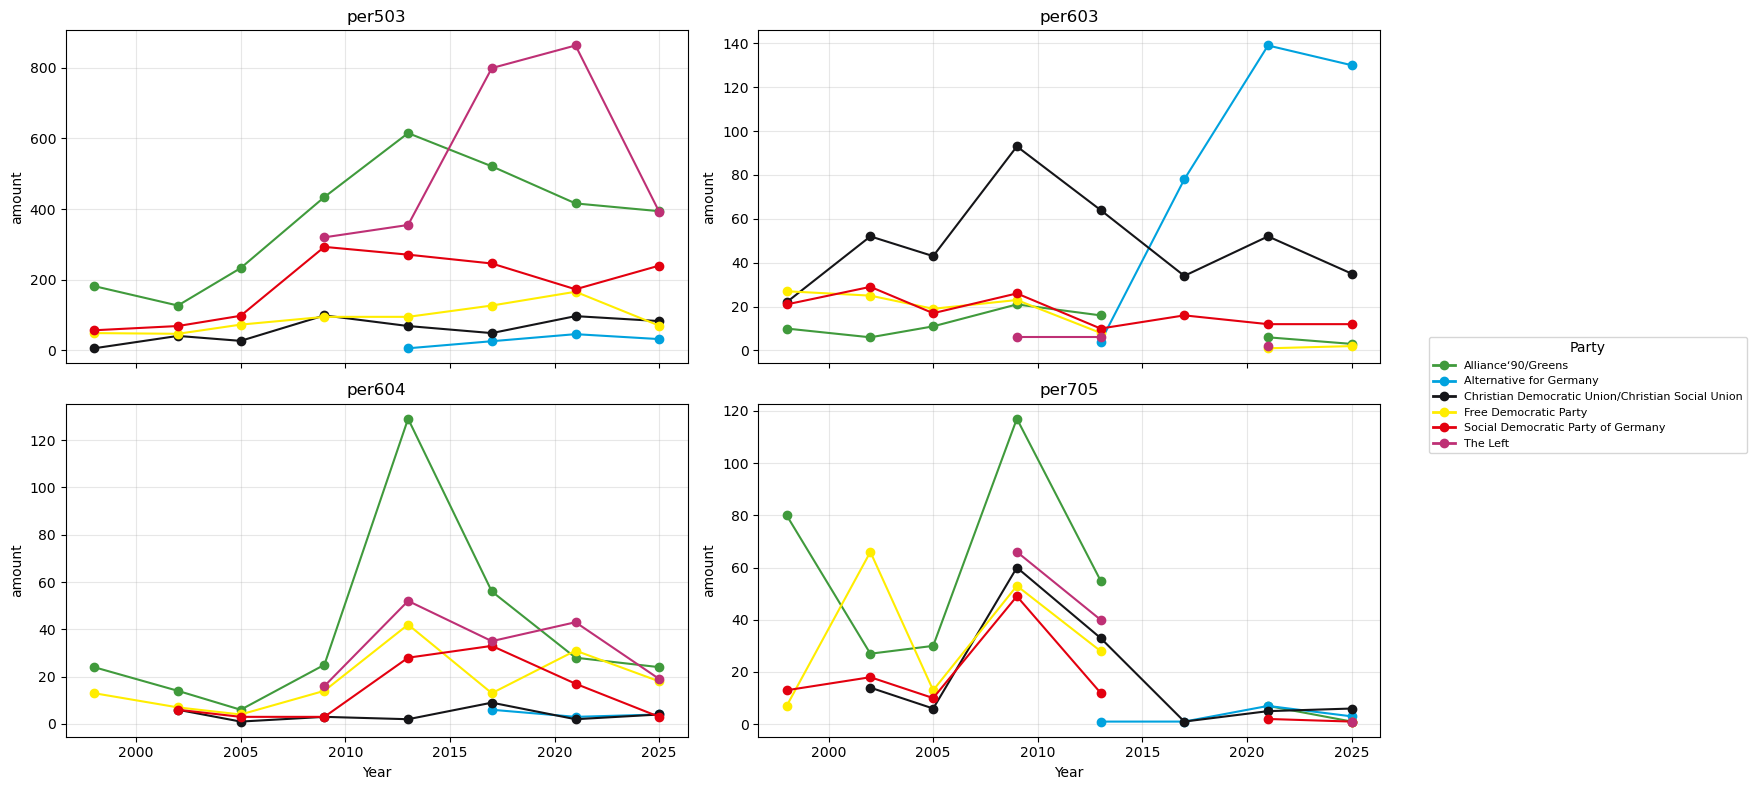

In [ ]:
tmp = tmp.copy()

#clean year for plotting
tmp["year"] = pd.to_numeric(tmp["year"], errors="coerce").astype("Int64")
tmp = tmp.dropna(subset=["year"])
tmp["year"] = tmp["year"].astype(int)

value_col = "amount" #plotting the full amount of mentions per party and year (no normalized against the manifesto length)

#german party colors
party_colors = {
    "Alliance'90/Greens": "#409A3C",
    "Alliance‘90/Greens": "#409A3C",
    "Alternative for Germany": "#00A2DE",
    "Christian Democratic Union/Christian Social Union": "#151518",
    "Free Democratic Party": "#FFED00",
    "Social Democratic Party of Germany": "#E3000F",
    "The Left": "#BE3075",
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 4 * 2), sharex=True) #plot
axes = fig.axes

fallback_color = "#808080"

codes = sorted(tmp["cmp_code"].unique())
for i, code in enumerate(codes):
    ax = axes[i]
    sub = tmp[tmp["cmp_code"] == code]
    pivot = (
        sub.pivot_table(index="year", columns="partyname", values=value_col, aggfunc="sum")
           .sort_index()
    )

    cols = list(pivot.columns)
    colors = [party_colors.get(p, fallback_color) for p in cols] #assign party colors

    pivot.plot(ax=ax, marker="o", legend=False, color=colors)
    ax.set_title(code)
    ax.set_xlabel("Year")
    ax.set_ylabel(value_col)
    ax.grid(True, alpha=0.3)

#big legend outside
parties_present = [p for p in tmp["partyname"].dropna().unique().tolist()]
parties_present_sorted = sorted(parties_present, key=lambda x: x.lower())

handles = [
    Line2D([0], [0], color=party_colors.get(p), marker="o", linewidth=2, label=p)
    for p in parties_present_sorted
]
labels = [h.get_label() for h in handles]

fig.legend(handles, labels, title="Party", fontsize=8, loc="center left", bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()

## INTERPRETATION
These four panels show how strongly German parties emphasize each topic (PER code) over time.

This data shows the absolute amount of mentions of a topic in a party's program in a specific year.

The overall amount of mentions are very different per topic. PER603, PER504 and PER705 are mentioned only about 15% of the amount that PER503 is mentioned.
________

PER503 Equality: Positive

Equality framing is most strongly associated with the Greens and The Left. For the Greens, the topics rise until the early 2010s and then taper off, while the Left family surges strongly after 2013 and peaks in the late 2010s to early 2020s before dropping by 2025. All other parties are comparatively lower on this dimension with the SPD in third place and then FDP, CDU/CSU and AfD in the bottom.

PER603 Traditional Morality: Positive

Here the pattern shifts. In the earlier years, this topic was emphasized by the CDU/CSU, but the AfD takes over this topic from 2017 onward. The order is switched compared to equality (the graph discussed before). Only the FDP does not stand out in either of the two plots, meaning neither equality nor traditional morality are specifically central to their party programs.

PER604 Traditional Morality: Negative

Negative traditional morality language peaks for all then-existing parties in the early 2010s and declines afterwards. This therefore seems to have been a time of changing traditions and going new ways. Why is a question for another research paper.

PER705 Underprivileged Minority Groups

This category shows a spike around 2009 for several parties, especially the Greens, followed by a broad decline after the early 2010s. This could reflect Germany’s obligations under the UN Convention on the Rights of Persons with Disabilities that became binding in 2009 or the global financial crisis hit Germany hard around 2008 to 2009. Interestingly, the peaks of PER604 and PER705 are not at the same time. The PER705 peak happens 4-5 years earlier than the PER604 peak.

attempting a more normalized view, as the absolute amount shown above is influenced by the length of each manifesto
this time plotting share_within_party_year, meaning the relative share of statements that referred to that specific PER indicator in one party's manifestos of one year

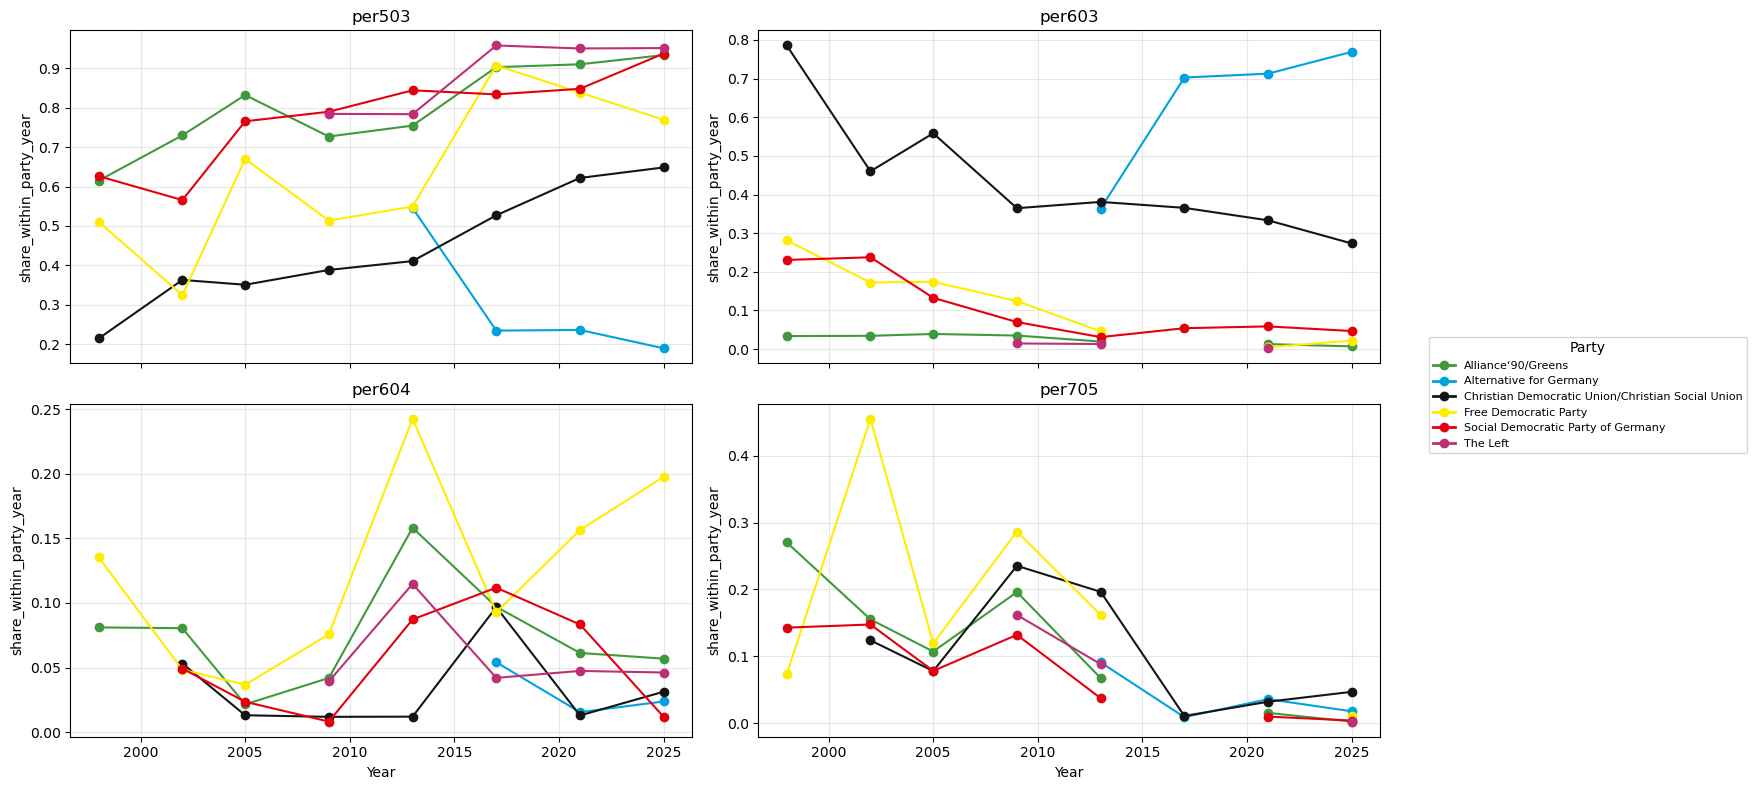

In [ ]:
value_col = "share_within_party_year"
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 4 * 2), sharex=True)
axes = fig.axes

for i, code in enumerate(codes):
    ax = axes[i]
    sub = tmp[tmp["cmp_code"] == code]

    pivot = (
        sub.pivot_table(index="year", columns="partyname", values=value_col, aggfunc="sum")
           .sort_index()
    )

    cols = list(pivot.columns)
    colors = [party_colors.get(p, fallback_color) for p in cols]

    pivot.plot(ax=ax, marker="o", legend=False, color=colors)
    ax.set_title(code)
    ax.set_xlabel("Year")
    ax.set_ylabel(value_col)
    ax.grid(True, alpha=0.3)

#big legend outside
parties_present = [p for p in tmp["partyname"].dropna().unique().tolist()]
parties_present_sorted = sorted(parties_present, key=lambda x: x.lower())

handles = [
    Line2D([0], [0], color=party_colors.get(p), marker="o", linewidth=2, label=p)
    for p in parties_present_sorted
]
labels = [h.get_label() for h in handles]

fig.legend(handles, labels, title="Party", fontsize=8, loc="center left", bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()

## INTERPRETATION

Across panels, the y axis shows the within party year share for each code, so higher values indicate that a party’s content in that year is more strongly concentrated in that specific code relative to the other codes in the set. Basically, we see how much each party talked about a topic compared to other topics. This helps with intraparty and interparty analysis.

For PER503 Equality: Positive, most parties converge toward very high shares over time, especially Alliance’90/Greens, SPD and the Left which reach roughly 0.85 to 0.95 in later years, while CDU/CSU increases steadily from a low baseline in the late 1990s to a clear majority share from 2017 on. In contrast, AfD shows the opposite trajectory, appearing around 2013 with a mid level but then dropping immediatly to a very low amount.

For PER603 Traditional Morality: Positive, AfD becomes the dominant party. From 2013 onward its share rises rapidly to about 0.7 to 0.8, indicating strong concentration in this topic compared with other parties. CDU/CSU starts very high in the late 1990s and then declines consistently. Similarly, starting from a lower share of below 1/§, the FDP and SPD also trend downward to near marginal shares. The Greens stay low throughout.

For PER604 Traditional Morality: Negative, shows a similar peak like the graph before. Interestingly, this time the FDP is in the lead.

For PER705 Underprivileged Minority Groups, FDP is again the most prominent case with a strong peak around 2013 and a renewed rise after 2017 into the 2020s.

## TFIDF

GOAL: Tfidf is a better version of simple word-count that tries to collect the words most important and unique in a cmp_code. It downweights words that appear across many cmp_code and upweights terms that are frequent within a specific cmp_code, making the top-term lists more representative of what distinguishes each group

In [ ]:
stopwords_de = set(stopwords.words("german"))

#typcial preprocessing 
df["text_clean"] = df["text"].str.lower() #lowercase
df["text_clean"] = df["text_clean"].str.replace(r"http\S+", " ", regex=True) #remove links
df["text_clean"] = df["text_clean"].str.replace(r"[.,]", " ", regex=True)  #remove . and ,

In [ ]:
vectorizer = TfidfVectorizer(
    ngram_range=(1,2), #unigrams and bigrams
    min_df=5, #keep only relevant words
    max_df=0.8, #remove super common words
    stop_words=list(stopwords_de) #stopwords
)

X = vectorizer.fit_transform(df["text_clean"])
feature_names = np.array(vectorizer.get_feature_names_out()) #words
X.shape

(11062, 3936)

now let's look at the important, defining terms per PER code and per party.

In [ ]:
for code in sorted(df["partyname"].unique()): #analyze terms per code
    print("\n==", code, "==")
    mask = (df["partyname"].to_numpy() == code)  #to numpy boolean mask
    Xi = X[mask]  #slice
    scores = np.asarray(Xi.mean(axis=0)).ravel() #mean score
    top_idx = scores.argsort()[::-1][:20] #display top 20
    print(pd.DataFrame({"term": feature_names[top_idx], "score": scores[top_idx]}))


== Alliance‘90/Greens ==
               term     score
0          menschen  0.021038
1            frauen  0.019682
2              mehr  0.012622
3      gesellschaft  0.011166
4          teilhabe  0.010886
5            müssen  0.010624
6             leben  0.010398
7             dafür  0.010074
8            kinder  0.009096
9     gerechtigkeit  0.008900
10      deutschland  0.008235
11            innen  0.007713
12          soziale  0.007224
13        einkommen  0.007094
14           setzen  0.007003
15         brauchen  0.006949
16            immer  0.006767
17  diskriminierung  0.006753
18           sollen  0.006599
19          stärken  0.006547

== Alternative for Germany ==
            term     score
0       familien  0.031562
1         kinder  0.031025
2            afd  0.029665
3             fu  0.026840
4        familie  0.024040
5         eltern  0.022176
6        kindern  0.017518
7    deutschland  0.010640
8             ab  0.010303
9         sollen  0.009716
10  gesellschaft

## INTERPRETATION
For Alliance’90/Greens, high weights for 'people', 'women', 'participation', 'society' and 'justice' plus an focus on 'discrimination' indicating a focus on inclusiveness and participation with equality framing.

Alternative for Germany is dominated by family-centred vocabulary and self-reference: 'families', 'children', 'parents' and 'family policy' co-occur with 'AfD' in addition to 'gender' and 'abortions' among the top terms which might hint at mobilisation around family norms and contentious culture war topics framed in national terms through 'Germany'.

CDU/CSU likewise foregrounds 'families', 'children', 'women' and 'society' but add governance by terms such as 'responsibility', 'support' and 'strengthen'.

The FDP vocabulary is organised around party identity and liberal values: 'Free Democrats', 'free', 'people', 'opportunities' and modal verbs such as 'should' and 'must' could point to an emphasis on individual freedom.

The Social Democratic Party of Germany shows a blend of social and equality topics. High scores for 'justice', 'social', 'income', 'participation' and 'equality' suggest an emphasis on redistribution and social inclusion.

The Left is similarly distributive and material in their tone. Vocabulary like 'euro' and 'percent' plus 'income' and 'work' points to a focus on wage and welfare questions.

# Co-occurances of terms

GOAL: Co-occurance of words helps understand what concepts are releated and to also better understand the topics that are relevant. It helps to extract frames and rhetoric strategies.

In [ ]:
def tokens(s):
    toks = [t for t in s.split() if len(t) > 2]
    return toks

pairs_by_party = {}
for code, g in df.groupby("partyname"):
    pair_counts = Counter()

    for s in g["text_clean"].dropna():
        toks = list(dict.fromkeys(tokens(s)))  #order-preserving unique tokens
        for u, v in itertools.combinations(sorted(toks), 2):
            pair_counts[(u, v)] += 1

    pairs = (
        pd.DataFrame(
            [(u, v, w) for (u, v), w in pair_counts.items() if w >= 10],
            columns=["term1", "term2", "weight"],
        )
        .sort_values("weight", ascending=False)
        .reset_index(drop=True)
    )

    pairs_by_party[code] = pairs

    print("\n==", code, "==")
    print(pairs.head(20))


== Alliance‘90/Greens ==
   term1   term2  weight
0    die     und     861
1    und     wir     657
2    der     und     588
3    wir  wollen     551
4    die     wir     522
5    der     die     489
6    für     und     472
7    die     für     406
8    und     von     405
9    die     von     385
10   der     wir     325
11   für     wir     323
12   und  wollen     319
13   mit     und     314
14  eine     und     295
15   den     und     275
16  auch     und     260
17   und  werden     258
18   die  wollen     255
19   die  werden     245

== Alternative for Germany ==
       term1   term2  weight
0        die     und     109
1        der     die      98
2        der     und      87
3        die     von      60
4        und     von      48
5        die  werden      46
6        der     von      41
7        die     ist      40
8        der     ist      39
9        afd     die      37
10       der  werden      37
11       und  werden      36
12       die     für      36
13      eine

I also tried plotting this, but ultimately I had to admit that co-occurance analysis is not super effective for this data. There is not much to gain. 

# Topic modelling

GOAL: Topic modelling is useful for mapping the main themes in a large collection of texts, discover recurring patterns of language and track how attention to certain issues shifts over time.

In [ ]:
n_topics = 8
topn = 15
random_state = 42

def show_topics(H, feature_names, topn=15):
    topics = []
    for ti, weights in enumerate(H):
        top_idx = np.asarray(weights).argsort()[::-1][:topn]
        topics.append((ti, feature_names[top_idx].tolist()))
    return topics

results = {}
X = X.tocsr()

for party, idx in df.groupby("partyname").indices.items():
    X_party = X[idx]

    nmf = NMF(n_components=n_topics, random_state=random_state)
    W = nmf.fit_transform(X_party)
    H = nmf.components_

    results[party] = show_topics(H, feature_names, topn=topn)

In [ ]:
results

{'Alliance‘90/Greens': [(0,
   ['menschen',
    'behinderung',
    'menschen behinderung',
    'behinderungen',
    'menschen behinderungen',
    'brauchen',
    'stärken',
    'junge',
    'zugang',
    'viele',
    'junge menschen',
    'gleichberechtigt',
    'ab',
    'vielen',
    'arbeitsmarkt']),
  (1,
   ['frauen',
    'männer',
    'männern',
    'frauen männern',
    'frauen männer',
    'fördern',
    'immer',
    'arbeit',
    'hälfte',
    'gleiche',
    'gleichberechtigung',
    'macht',
    'gleichstellung',
    'gleichberechtigt',
    'mehr frauen']),
  (2,
   ['gerechtigkeit',
    'mehr',
    'mehr gerechtigkeit',
    'frage gerechtigkeit',
    'frage',
    'soziale',
    'soziale gerechtigkeit',
    'globale',
    'mehr soziale',
    'freiheit',
    'sozialer gerechtigkeit',
    'sozialer',
    'unserer',
    'globaler',
    'schafft']),
  (3,
   ['teilhabe',
    'soziale',
    'gesellschaftliche',
    'gesellschaftliche teilhabe',
    'stärken',
    'soziale teilhabe

I tried to name the topics based on the words outputted. I chose to only work on the parties that are currently in the Bundestag or were there last term.

## INTERPRATEATION

Alliance‘90/Greens

* **0:** disability inclusion and accessibility
* **1:** gender equality in work and opportunities
* **2:** social and global justice and freedom
* **3:** participation through education and self determination
* **4:** anti discrimination and securing rights
* **5:** green party identity and equality policy life models
* **6:** more justice for families income and accessibility
* **7:** children poverty diversity and social participation

Alternative for Germany

* **0:** family policy fundamentals traditional model and tax splitting
* **1:** children parents rights and early childhood framing
* **2:** birth rate demography and support for stable families
* **3:** family mother father and protection of the nuclear family
* **4:** tokenization noise and corrupted terms fu hren
* **5:** opposition to abortion and rights framing
* **6:** involving fathers and work family balance
* **7:** anti gender ideology and binary sex order

Christian Democratic Union/Christian Social Union

* **0:** christian values and core principles
* **1:** strengthening and relieving families family policy
* **2:** churches values and social cohesion
* **3:** parental responsibility child rearing and childrens future
* **4:** defending core principles marriage tax splitting constitution religious education
* **5:** marriage and family and work family compatibility
* **6:** disability inclusion participation and work
* **7:** intergenerational justice pensions and fiscal solidity

Free Democratic Party

* **0:** liberal agenda digital modernization and accessibility
* **1:** self determined living and disability inclusion
* **2:** fdp party profile integration and intergenerational justice
* **3:** work family balance and new responsibility partnerships
* **4:** equal opportunity regardless of origin equal rights
* **5:** social insurance benefits and transitions for couples
* **6:** responsibility for each other and life partnerships
* **7:** more opportunities public service and leadership positions

Social Democratic Party of Germany

* **0:** social justice generations and social security
* **1:** modern society cohesion and fair opportunities
* **2:** social security stability and social rights
* **3:** gender equality women men and equal opportunity
* **4:** work family balance and time policy
* **5:** supporting families income and single parents
* **6:** participation opportunity and disability inclusion
* **7:** fair financing tax burden and redistribution

The Left

* **0:** poverty participation accessibility and disability
* **1:** social inequality global justice and fighting it
* **2:** numbers and tax redistribution in billions
* **3:** party profile the left demands fights advocates
* **4:** accessible public institutions and strengthening rights
* **5:** socially fair distribution and a just energy transition
* **6:** east west equality wages and equal rights
* **7:** high incomes wealth and progressive taxation


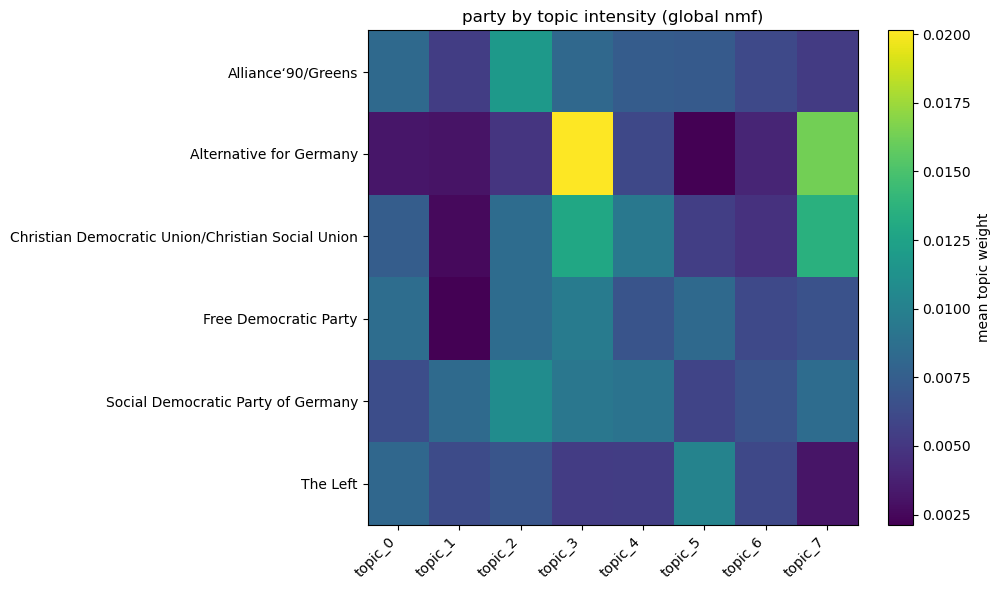

In [ ]:
#global nmf
nmf = NMF(n_components=n_topics, random_state=random_state)
W = nmf.fit_transform(X)

#party x topic mean weight
W_df = pd.DataFrame(W, columns=[f"topic_{i}" for i in range(n_topics)])
W_df["partyname"] = df["partyname"].values

party_topic = W_df.groupby("partyname").mean()

#plot heatmap with matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(party_topic.values, aspect="auto")
plt.yticks(range(party_topic.shape[0]), party_topic.index)
plt.xticks(range(party_topic.shape[1]), party_topic.columns, rotation=45, ha="right")
plt.colorbar(label="mean topic weight")
plt.title("party by topic intensity (global nmf)")
plt.tight_layout()
plt.show()

In [ ]:
#topic keywords
rows = []
for ti in range(n_topics):
    weights = H[ti]
    top_idx = np.argsort(weights)[::-1][:topn]
    terms = feature_names[top_idx].tolist()
    rows.append({"topic": f"topic_{ti}", "top_terms": terms})

In [ ]:
rows

[{'topic': 'topic_0',
  'top_terms': ['menschen',
   'behinderungen',
   'menschen behinderungen',
   'leben',
   'viele',
   'viele menschen',
   'behinderung',
   'menschen behinderung',
   'zugang',
   'sollen',
   'mehr',
   'gesellschaft',
   'millionen',
   'teilhabe',
   'einkommen']},
 {'topic': 'topic_1',
  'top_terms': ['soziale',
   'gerechtigkeit',
   'soziale gerechtigkeit',
   'ungleichheit',
   'soziale ungleichheit',
   'sozialen',
   'mehr',
   'zusammen',
   'weltweit',
   'statt',
   'sozialer',
   'globale',
   'verschärft',
   'deutschland',
   'kämpfen']},
 {'topic': 'topic_2',
  'top_terms': ['prozent',
   'einkommen',
   '50',
   '50 prozent',
   'ab',
   '53 prozent',
   '53',
   'besteuert',
   'hohe',
   'vermögen',
   'reichsten',
   'steuersatz',
   'hohe einkommen',
   'beträgt',
   'million']},
 {'topic': 'topic_3',
  'top_terms': ['linke',
   'linke fordert',
   'fordert',
   'linke setzt',
   'setzt',
   'linke steht',
   'steht',
   'kämpft',
   'linke

## INTERPRETATION

Here is how I would name the topics, one sentence each:

* **topic_0:** disability inclusion and participation
* **topic_1:** social inequality and social justice
* **topic_2:** taxation and wealth
* **topic_3:** party self positioning and activist rhetoric
* **topic_4:** accessibility, rights and inclusion
* **topic_5:** socially fair distribution and just transition
* **topic_6:** east west equality, wages and pensions
* **topic_7:** fiscal quantities and revenue arguments


## INTERPRETATION

Given the topics identified above, here is an interpretation of the heatmap:

Party messaging and positioning is a clear outlier for Alternative for Germany. It is by far the strongest party topic signal in the whole plot. CDU/CSU and BSW are also relatively high on party messaging and positioning, but noticeably below AfD.

High income and wealth taxes is strongest for Alliance‘90/Greens and is also fairly high for SPD.

Fiscal totals and revenue figures is high for AfD and CDU/CSU, while it is very low for The Left. That topic separates those parties strongly in this model.

The Left stands out on socially fair transition, where it is higher than the others (most other parties are mid to low there).

FDP looks the most even across topics, without a single dominant peak. Social justice and inequality is comparatively low for FDP.